# Starbucks Capstone Project

<img src="coffee.jpg"/>



### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline
import pandas as pd
import numpy as np
import math
import json
import pandasql as ps
from tqdm import tqdm_notebook as tqdm
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
sns.set()

from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD, accuracy
from surprise import evaluate, print_perf
from math import sqrt

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
pd.set_option('display.max_columns', None)

In [176]:
#defining all necessary functions

def define_reward (value):
    line = str (value)
    if line [50:56] == 'reward':
        if line [-5] == ':':
            return int ((line [-3:-1]))
        else:     
            return int (line [-2])
    else: 
        return np.nan
    
def define_offer (value):
    line = str (value)
    if line [2:7] == 'offer': 
        return line [14:46]
    else: 
        return np.nan
    
def define_amount (value):
    line = str (value)
    if line [2:8] == 'amount': 
        return round (float (line [11:-1]), 2)
    else: 
        return np.nan

def define_subtype (value):
    if portfolio [portfolio['id'] == value].shape[0] != 0:
        return np.array(portfolio [portfolio['id'] == value] ['subtype'])[0]
    else:
        return np.nan
    
def userid_mapper():
    """
    
    """
    coded_dict = dict()
    cter = 1
    userid_encoded = []
    
    for val in df['person']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        userid_encoded.append(coded_dict[val])
    return userid_encoded, coded_dict


def validation_func (test_matrix, predict_train_matrix, is_train =False, verbose=True):
    #will be looping over common customers only
    test_idx = test_matrix.index.intersection (predict_train_matrix.index)
    test_cols = test_matrix.columns

    sse_accum = 0
    diff = 0
    acc = []

    for i in test_idx: 
        for j in test_cols: 
            if test_matrix.at [i,j]>=0:
                # compute the error as the actual minus the dot product of the user and offer latent features
                diff = test_matrix.at [i,j] - predict_train_matrix.at [i,j]
                        
                # Keep track of the sum of squared errors for the matrix
                sse_accum += diff**2
                acc.append (abs (diff))

    #deviding on the overall not null values in test_matrix
    mse_error = sse_accum/(test_matrix.notnull().sum ().sum())
    acc_test = 1 - sum (acc)/(test_matrix.notnull().sum ().sum())

    if (is_train == False)&(verbose): 
        print ('\n')
        print ('MSE on the test set is: ', mse_error)
        print ('RMSE on the test set is: ', sqrt(mse_error))
        print ('Accuracy on the test set is: ', acc_test)
        print ('\n')
    if (is_train == True)&(verbose): 
        print ('\n')
        print ('MSE on the train set is: ', mse_error)
        print ('RMSE on the train set is: ', sqrt(mse_error))
        print ('Accuracy on the train set is: ', acc_test)
        print ('\n')
    #if no need for printing just return values of MSE and Accuracy
    if verbose == False: 
        return mse_error, acc_test

In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
#adding column into portfolio that will define subtype
portfolio ['subtype'] = portfolio['offer_type']+ '_'+portfolio['duration'].map (str)+'_'+portfolio['difficulty'].map(str)

In [6]:
portfolio.shape 

(10, 7)

In [7]:
portfolio ['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [8]:
#converting "became_member_on" into a date format  
profile ['became_member_on'] = pd.to_datetime (profile ['became_member_on'], format = '%Y%m%d', errors = 'coerce')

In [9]:
subscrip_df = profile.groupby(['became_member_on'], as_index=False).agg({'id':'count'})
subscrip_df.set_index ('became_member_on', inplace = True)
subscrip_Y_df = subscrip_df['id'].resample('Y').sum ()
subscrip_M_df = subscrip_df['id'].resample('M').sum ()
subscrip_D_df = subscrip_df['id'].resample('D').sum ()

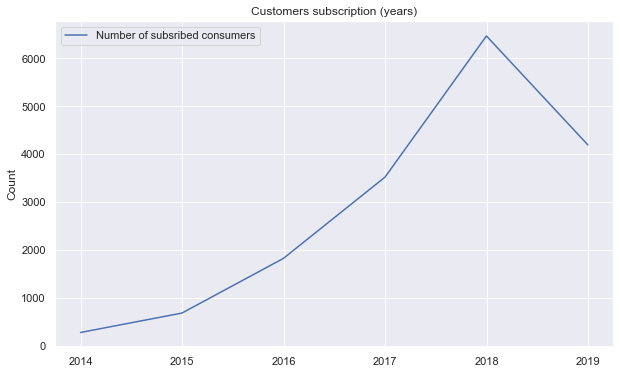

In [10]:
#Years subscription
x = subscrip_Y_df.index
fig, ax = plt.subplots(figsize = (10,6))
y1 = subscrip_Y_df 
ax.set_ylabel('Count')
ax.plot(x, y1, label = 'Number of subsribed consumers')
ax.set_title("Customers subscription (years)")
plt.legend (loc = 'best')
plt.show()

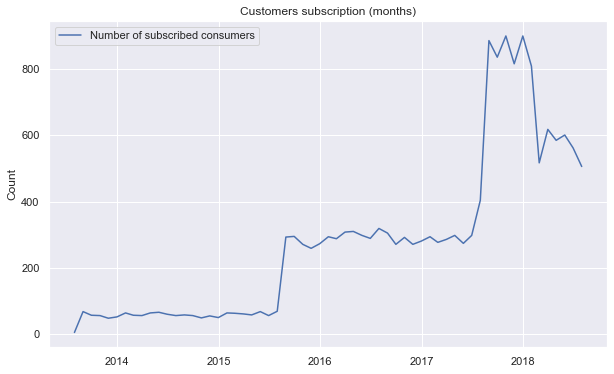

In [11]:
#Months subscription
x = subscrip_M_df.index
fig, ax = plt.subplots(figsize = (10,6))
y1 = subscrip_M_df 
ax.set_ylabel('Count')
ax.plot(x, y1, label = 'Number of subscribed consumers')
ax.set_title("Customers subscription (months)")
plt.legend (loc = 'best')
plt.show()

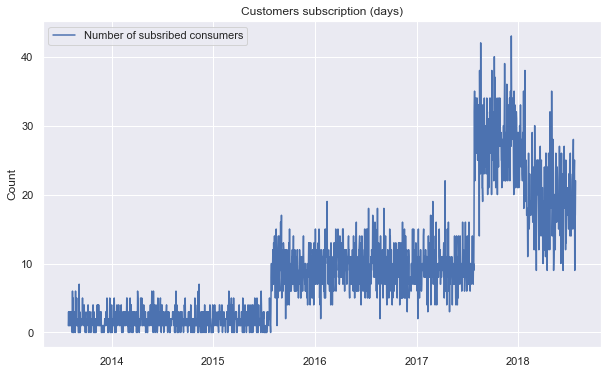

In [12]:
#subscription in days
x = subscrip_D_df.index
fig, ax = plt.subplots(figsize = (10,6))
y1 = subscrip_D_df 
ax.set_ylabel('Count')
ax.plot(x, y1, label = 'Number of subsribed consumers')
ax.set_title("Customers subscription (days)")
plt.legend (loc = 'best')
plt.show()

In [13]:
profile.head (n=10)

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,2016-11-22,None,8974fc5686fe429db53ddde067b88302,NaN


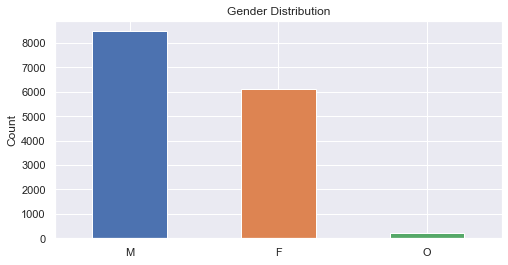

In [14]:
#plotting gender distribution 
fig, ax = plt.subplots(figsize = (8,4))
profile.gender.value_counts().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Gender Distribution')
ax.set_ylabel('Count')
plt.show ()

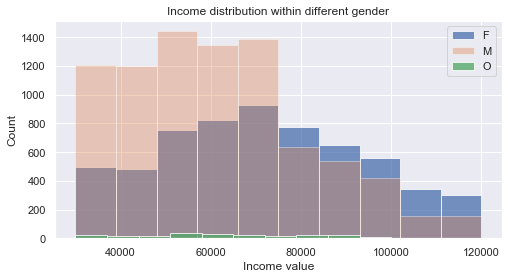

In [15]:
# plot income distribution histogram
fig, ax = plt.subplots(figsize = (8,4))

ax.hist(profile[profile.gender == 'F']['income'], alpha=0.76, label='F')
ax.hist(profile[profile.gender == 'M']['income'], alpha=0.37, label='M')
ax.hist(profile[profile.gender == 'O']['income'], alpha=0.78, label='O')
ax.set_xlabel('Income value')
ax.set_ylabel('Count')
ax.set_title('Income distribution within different gender')
ax.legend()
plt.show ()

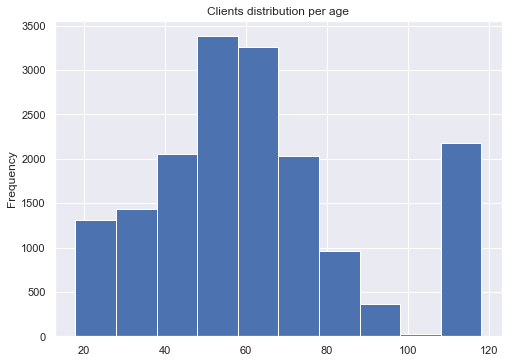

In [16]:
#plotting customers distribution by age
profile ['age'].plot (kind = 'hist',
                    title = 'Clients distribution per age',
                    figsize = (8, 5.8)
                      )

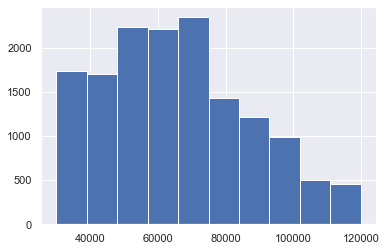

In [17]:
#verifying income distribution. 
profile ['income'].hist ();

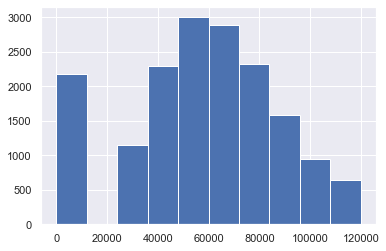

In [18]:
#As long as for income non-missing values nobody has income of zero 
#then let's fill NaN for income missing with zeros and check how this affects the diagram

#let's make a temp copy of profile data so to check missing values
profile_tmp = profile.copy ()
profile_tmp ['income'].fillna (0, inplace =True)
#let's mark missing gender as special - 'S'
profile_tmp ['gender'].fillna ('S', inplace =True)


profile_tmp ['income'].hist ();

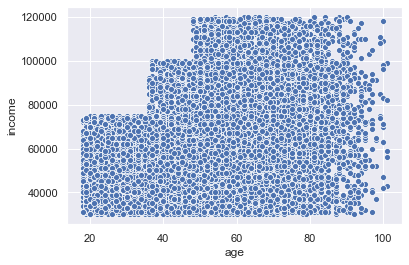

In [19]:
#
ax = sns.scatterplot (x = 'age', y= 'income', data = profile)
plt.show ()

Strict borders on the left and top side of the diagram above indicate artificial nature of the data where apparently there are income limits set for each age range.

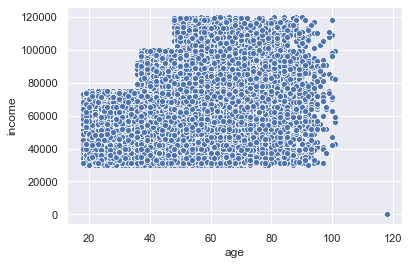

In [20]:
ax = sns.scatterplot (x='age', y='income', data = profile_tmp)

(2175, 5)
(2175, 5)


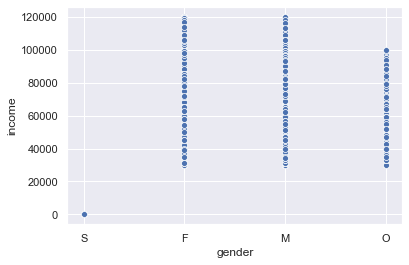

In [21]:
#let's check out deeply if customers with missing values for gender are the same 
#customers with income missing 
print (profile_tmp [profile_tmp ['income'] == 0].shape)
print (profile_tmp [profile_tmp ['gender'] == 'S'].shape)
ax = sns.scatterplot (x= 'gender', y='income', data = profile_tmp)

In [22]:
print (profile_tmp [profile_tmp ['income'] == 0].head (n=3))

   age became_member_on gender                                id  income
0  118       2017-02-12      S  68be06ca386d4c31939f3a4f0e3dd783     0.0
2  118       2018-07-12      S  38fe809add3b4fcf9315a9694bb96ff5     0.0
4  118       2017-08-04      S  a03223e636434f42ac4c3df47e8bac43     0.0


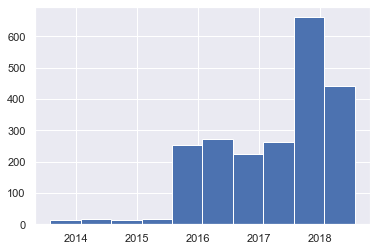

In [23]:
profile_tmp [profile_tmp ['income'] == 0] ['became_member_on'].hist();

In [24]:
#checking if in the datset we have people at age 118 but at the same time not in the special group
print ('Number of customers that have indicated income but at the same time they are at age 118: ', \
       profile_tmp [(profile_tmp ['income'] != 0)& (profile_tmp ['age'] == 118)].shape [0])

Number of customers that have indicated income but at the same time they are at age 118:  0


**Observations for the profile dataset**  
From the above we can see that customers with missing values for gender are the same customers with income missing. 
They form a special group of customers. People with age 118 presented ***only*** in this group.  
Subscription for them mostly done from 2016 onwards while in 2014 and 2015 only few of them subscribed.

In [25]:
#as a result of above analysis it appears that we may fullfill missing values in gender as 'S'
#and missing values in income with zeroes as it will not interfere with other group of customers
profile = profile_tmp.copy ()
profile.head (n=10)

,age,became_member_on,gender,id,income
0,118,2017-02-12,S,68be06ca386d4c31939f3a4f0e3dd783,0.0
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,S,38fe809add3b4fcf9315a9694bb96ff5,0.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,S,a03223e636434f42ac4c3df47e8bac43,0.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,2017-09-25,S,8ec6ce2a7e7949b1bf142def7d0e0586,0.0
7,118,2017-10-02,S,68617ca6246f4fbc85e91a2a49552598,0.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,2016-11-22,S,8974fc5686fe429db53ddde067b88302,0.0


In [26]:
profile.describe ()

,age,income
count,17000.000000,17000.000000
mean,62.531412,57037.000000
std,26.738580,29734.044501
min,18.000000,0.000000
25%,45.000000,40000.000000
50%,58.000000,59000.000000
75%,73.000000,76000.000000
max,118.000000,120000.000000


In [27]:
profile.shape

(17000, 5)

In [28]:
profile.isnull ().sum ()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [29]:
profile['gender'].unique ()

array(['S', 'F', 'M', 'O'], dtype=object)

In [30]:
#checking if the values missing for gender and income for the same customers

profile [profile ['income'].isnull ()].head (n=10)


,age,became_member_on,gender,id,income


In [31]:
profile.dtypes

age                          int64
became_member_on    datetime64[ns]
gender                      object
id                          object
income                     float64
dtype: object

In [32]:
np.NaN

nan

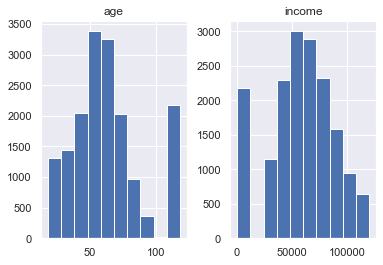

In [33]:
profile.hist ();

In [34]:
transcript.head (n=10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [35]:
transcript ['event'].unique ()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [36]:
transcript.shape

(306534, 4)

In [37]:
#transcript [transcript ['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

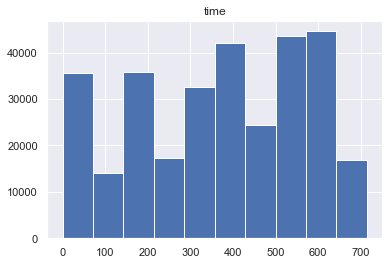

In [38]:
transcript.hist ();

In [39]:
transcript.describe ()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


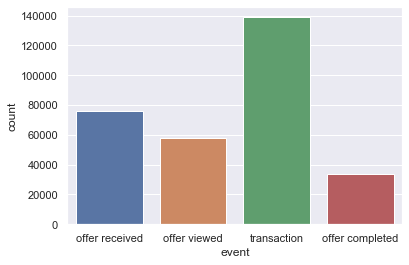

In [40]:
sns.countplot('event', data= transcript)

In [41]:
profile.head (n=5)

,age,became_member_on,gender,id,income
0,118,2017-02-12,S,68be06ca386d4c31939f3a4f0e3dd783,0.0
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,S,38fe809add3b4fcf9315a9694bb96ff5,0.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,S,a03223e636434f42ac4c3df47e8bac43,0.0


In [42]:
transcript.tail (n=7)

,event,person,time,value
306527,offer completed,24f56b5e1849462093931b164eb803b5,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306528,transaction,5ca2620962114246ab218fc648eb3934,714,{'amount': 2.2}
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [43]:
#adding new columns to transcript
transcript = transcript.join (pd.DataFrame ( { 'offer_id': np.nan, 'amount': np.nan,\
                                               'reward_received': np.nan, 'offer_used':np.nan}, index = transcript.index))

In [44]:
transcript ['reward_received'] = transcript ['value'].apply (define_reward)
transcript ['offer_id'] = transcript ['value'].apply (define_offer)
transcript ['amount'] = transcript ['value'].apply (define_amount)
transcript.isnull ().sum ()

event                   0
person                  0
time                    0
value                   0
offer_id           138953
amount             167581
reward_received    272955
offer_used         306534
dtype: int64

In [45]:
transcript .head (n=5)

,event,person,time,value,offer_id,amount,reward_received,offer_used
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [46]:
transcript['amount'].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

Text(0.5, 1.0, 'Ditribution of frequency of the overall amount spent by consumers')

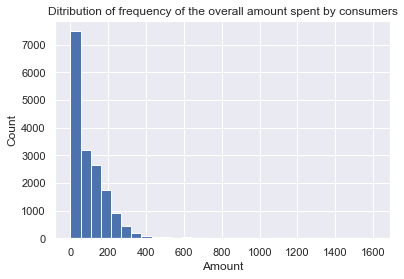

In [47]:
transcript.groupby('person')['amount']. sum ().hist(bins=30)
plt.xlabel('Amount')
plt.ylabel('Count')
plt.title('Ditribution of frequency of the overall amount spent by consumers')

Text(0.5, 1.0, 'Ditribution of mean of the amount spent by consumers')

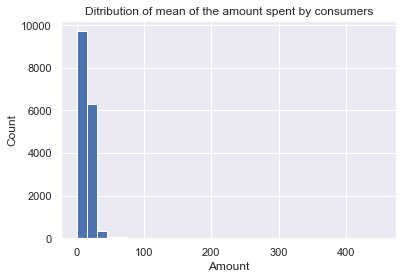

In [48]:
transcript.groupby('person')['amount'].mean().hist(bins=30)
plt.xlabel('Amount')
plt.ylabel('Count')
plt.title('Ditribution of mean of the amount spent by consumers')

In [49]:
transcript ['person'].nunique ()

17000

In [50]:
transcript.shape 

(306534, 8)

In [51]:
profile ['id'].nunique ()

17000

**So there should be then 1 to 1 correlation. To be verified!**

In [52]:
unique_cust_profile = set (profile ['id'].unique ())
unique_cust_transcript = set (transcript ['person'].unique ())
len (unique_cust_profile.intersection (unique_cust_transcript))

17000

So all the customers from transcript have corresponding data in profile

**Показать какие есть тренды по тратам по месяцам, по годам когда офферы не влияют и когда они уже влияют и на какой день влияют. составить хитмап того на какой день офферы просмотрены и каково среднее время просмотра оффера**

In [53]:
#combining transcript and portfolio

df = transcript.merge (portfolio, left_on= 'offer_id', right_on= 'id', how= 'left', validate= 'many_to_one')

#dropping unnessary columns
df.drop (columns = ['value', 'id'], inplace = True)

#adding a column with time in days
df ['time_days'] = (df ['time']/24).round (decimals = 2)

df.head (n=5)

,event,person,time,offer_id,amount,reward_received,offer_used,channels,difficulty,duration,offer_type,reward,subtype,time_days
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0,bogo_7_5,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,"[web, email]",20.0,10.0,discount,5.0,discount_10_20,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,"[web, email, mobile]",10.0,7.0,discount,2.0,discount_7_10,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,"[web, email, mobile, social]",10.0,10.0,discount,2.0,discount_10_10,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,"[web, email, mobile, social]",10.0,5.0,bogo,10.0,bogo_5_10,0.0


In [54]:
df [(df ['reward_received'] >0) & (df ['event'] != 'offer completed')] 

,event,person,time,offer_id,amount,reward_received,offer_used,channels,difficulty,duration,offer_type,reward,subtype,time_days


Which means that rewards can be gained only when offer completed.

In [55]:
df ['event'].unique () 

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [56]:
#merging with profile df
df = df.merge (profile, left_on = 'person', right_on = 'id', how = 'left', validate= 'many_to_one')

#dropping unnessary column
df.drop (columns = ['id'], inplace = True)
df.head (n=5)

,event,person,time,offer_id,amount,reward_received,offer_used,channels,difficulty,duration,offer_type,reward,subtype,time_days,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0,bogo_7_5,0.0,75,2017-05-09,F,100000.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,"[web, email]",20.0,10.0,discount,5.0,discount_10_20,0.0,118,2017-08-04,S,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,"[web, email, mobile]",10.0,7.0,discount,2.0,discount_7_10,0.0,68,2018-04-26,M,70000.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,"[web, email, mobile, social]",10.0,10.0,discount,2.0,discount_10_10,0.0,118,2017-09-25,S,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,"[web, email, mobile, social]",10.0,5.0,bogo,10.0,bogo_5_10,0.0,118,2017-10-02,S,0.0


In [57]:
event = 'offer received'
person = '78afa995795e4d85b5d9ceeca43f5fef'
offer_id = '9b98b8c7a33c4b65b9aebfe6a799e6d9'
duration = 7.0
time0 = 0

df [(df ['event'] == 'offer viewed') & (df ['offer_id'] == offer_id) & (df ['time'] <= (time0 + duration)) & (df['person'] == person)]

,event,person,time,offer_id,amount,reward_received,offer_used,channels,difficulty,duration,offer_type,reward,subtype,time_days,age,became_member_on,gender,income
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0,bogo_7_5,0.25,75,2017-05-09,F,100000.0


In [58]:
print ('Number of customers that received any offer', df [df ['event'] == 'offer received'] ['person'].nunique ())
print ('Conclusion: 6 persons never recieved any offer')

Number of customers that received any offer 16994
Conclusion: 6 persons never recieved any offer


***Проверить df на предмет того, что по некоторым пользователем нет данных!***

In [59]:
#delete afterwards
df[ df['event'] =='transaction'].shape

len (df [df ['event'] == 'offer received'] ['person'].unique () )

person = '78afa995795e4d85b5d9ceeca43f5fef'

df [(df ['person'] == person)].groupby (['offer_id']).diff ()

,time,amount,reward_received,offer_used,difficulty,duration,reward,time_days,age,became_member_on,income
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
15561,6.0,NaN,NaN,NaN,0.0,0.0,0.0,0.25,0.0,0 days,0.0
47582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
47583,126.0,NaN,NaN,NaN,0.0,0.0,0.0,5.25,0.0,0 days,0.0
49502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
53176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
85291,48.0,NaN,NaN,NaN,0.0,0.0,0.0,2.00,0.0,0 days,0.0
87134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
92104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
141566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN


In [60]:
df [(df ['event'] == 'offer completed') & (df ['reward_received'] != df ['reward'])].shape

(0, 18)

In [61]:
df [(df ['event'] == 'offer completed') & (df ['offer_type'] == 'informational')].shape

(0, 18)

Which means that whenever an offer completed reward recived in full

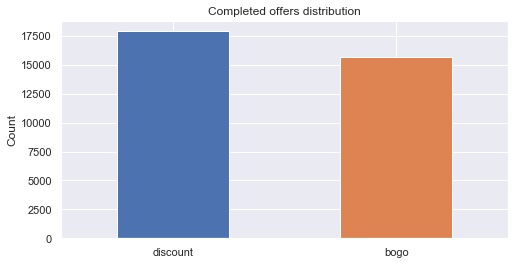

In [62]:
#let's visualize distribution of offer type within completed offers

offers_completed = df[df ['event'] == 'offer completed']

#plotting gender distribution 
fig, ax = plt.subplots(figsize = (8,4))
offers_completed.offer_type.value_counts().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Completed offers distribution')
ax.set_ylabel('Count')
plt.show ()

As we can see no entry for informational offers presented.

**There duplicates in offer completed**
Check this person. 978d48db5c714a4490d904412f85b502
Eliminate duplicates from all dataframes!
Those are not duplicates but different offers. 

***Показать распределение офферов, сколько было направлено, просмотрено и т.п. в деталях по типам офферов***

In [63]:
df [df ['event'] == 'offer completed'].shape

(33579, 18)

In [64]:
df [df ['event'] == 'transaction'].shape

(138953, 18)

It appears that a person may receive several offers while the first is still active. 

Why the numner of unique offers per a person is almost equal for viewed and received? ***put above a single person and check result***

In [65]:
#df.dtypes

In [66]:
def trans_affected_func (df): 
    """
    A function that returns dataframe with transactions.  
    For transactions that were affected by any offer following fields filled: 
    'offer_id',
    'offer_type'
    
    INPUT: 
    OUTPUT:
    """
    
    #slice subsets with offers received, viewed, completed and transactions
    offer_rec_df = df [df ['event'] =='offer received'].copy ()
    offer_view_df = df [df ['event'] =='offer viewed'].copy ()
    offer_compl_df = df [df ['event'] =='offer completed'].copy ()
    trans_df = df[df['event'] == 'transaction'].copy ()
    
    #adding a column with a date (in hours) when offer's affect is ending
    offer_rec_df ['offer_end_time'] = offer_rec_df ['time'] + offer_rec_df ['duration']*24 
    
    #firstly running through informational offers
    for i in tqdm (offer_view_df [offer_view_df['offer_type']=='informational'].index): 
    
        #saving parameters
        person = offer_view_df.at [i, 'person']
        offer_id = offer_view_df.at [i, 'offer_id']
        time_view = offer_view_df.at [i, 'time']
        
        #finding offers received by this person with the same offer id
        #taking only offers that were recieved before the offer view time
        #sorting by the time from the newest to the oldest
        offers_received = offer_rec_df [(offer_rec_df ['person'] == person)&\
                                        (offer_rec_df ['offer_id'] == offer_id) &\
                                        (offer_rec_df ['time'] <= time_view) & \
                                        (offer_rec_df ['offer_end_time'] >= time_view)].copy ().\
                                        sort_values (by = ['time'], ascending = False)
        
        #if no such offers were received by this person or viewed post the affect time then skip
        if offers_received.shape [0] == 0: 
            continue 
            
        offers_received.reset_index (drop = True, inplace = True)
            
        criteria =  (trans_df ['time'] >= offers_received.at [0, 'time']) &\
                    (trans_df ['time'] >= time_view)&\
                    (trans_df ['time'] <= offers_received.at [0, 'offer_end_time'])&\
                    (trans_df ['person'] == person)
        
        trans_df.at [criteria, 'offer_type'] =  'informational'   
        trans_df.at [criteria, 'offer_id'] = offer_id
            
    #now running through bogo and discount and if by chance a transaction happened within informational offer 
    #affect time and at the same time it was done so to complete discount or bogo and the completion happened
    #then we shall consider transaction affected by bogo or discount rather than informational 
    for i in tqdm (offer_view_df [offer_view_df['offer_type']!='informational'].index): 
    
        #saving parameters
        person = offer_view_df.at [i, 'person']
        offer_id = offer_view_df.at [i, 'offer_id']
        time_view = offer_view_df.at [i, 'time']
        
        #finding offers received by this person with the same offer id
        #taking only offers that were recieved before the offer view time
        #sorting by the time from the newest to the oldest
        offers_received = offer_rec_df [(offer_rec_df ['person'] == person)&\
                                        (offer_rec_df ['offer_id'] == offer_id) &\
                                        (offer_rec_df ['time'] <= time_view) & \
                                        (offer_rec_df ['offer_end_time'] >= time_view)].copy ().\
                                        sort_values (by = ['time'], ascending = False)
        
        #if no such offers were received by this person or viewed post the affect time then skip
        if offers_received.shape [0] == 0: 
            continue 
        
        #taking received offer that is the closest by time to the time of offer completed
        #in condition that there is a transaction between them
        #and checking if offer was completed within offer deadline
        
        offers_received.reset_index (drop = True, inplace = True)
        time_rec = offers_received.at [0, 'time']
        time_rec_end = offers_received.at [0, 'offer_end_time']
        
        #finding offers completed by this person with the same offer id
        #taking only offers that were completed before deadline
        #we will check transactions that were done to make offer completed. partial completion will not be taken
        #into consideration as we consider that if offer was not completed fully then it did not affect customer
        #sorting by the time so to fine closest completed offer
        offers_completed=offer_compl_df[(offer_compl_df ['person'] == person)&\
                                        (offer_compl_df ['offer_id'] == offer_id) &\
                                        (offer_compl_df ['time'] >= time_rec) & \
                                        (offer_compl_df ['time'] <= time_rec_end)&\
                                        (offer_compl_df ['time'] >= time_view)].copy ().\
                                        sort_values (by = ['time'], ascending = True)
        
        #if no such offers were completed by this person then we don't have transactions affected
        if offers_completed.shape [0] == 0: 
            continue 
        
        #reset index
        offers_completed.reset_index (drop = True, inplace = True)
        
        #print (time_rec,time_view, time_rec_end,offers_completed.at [0, 'time'], offer_id)
        
        criteria = (trans_df ['time'] >= time_rec) &\
                   (trans_df ['time'] >= time_view)&\
                   (trans_df ['time'] <= time_rec_end)&\
                   (trans_df ['time'] <= offers_completed.at [0, 'time'])&\
                   (trans_df ['person'] == person)
        
        trans_df.at [criteria, 'offer_type'] =  offers_completed.at [0, 'offer_type']   
        trans_df.at [criteria, 'offer_id'] = offer_id
        
    return trans_df

In [67]:
#trans_affected = trans_affected_func (df [df ['person'] == '978d48db5c714a4490d904412f85b502'])
#df [df ['person'] == '978d48db5c714a4490d904412f85b502']

***We can see that a customer may receive the same offer twice while the first one is still available to be filled.***

Function takes about an hour to complete running through all the viewed offers. Uncomment below to run it

In [68]:
#********************Uncomment below to run it*********************************

#trans_affected = trans_affected_func (df)
#trans_affected.to_csv ('trans_aff.csv')

In [69]:
trans_affect = pd.read_csv ('trans_aff.csv')

trans_affect.set_index (keys = 'Unnamed: 0', drop = True, inplace = True)

***Count number of rewards received as a result of promo affect and how much eventually (occassionally)***
Может такое быть, что транзакция попадают под действие двух офферов сразу и в таком случае, не очевидно, какой оффер повлиял, 
я предполагаю, что тот, что более свежий близкий к транзакции по времени (пример 24115a61df25473e84a8a03f3c98de1a)!
пример когда оба оффера завершились в одно время

In [70]:
df.head (n=10)

,event,person,time,offer_id,amount,reward_received,offer_used,channels,difficulty,duration,offer_type,reward,subtype,time_days,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0,bogo_7_5,0.0,75,2017-05-09,F,100000.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,"[web, email]",20.0,10.0,discount,5.0,discount_10_20,0.0,118,2017-08-04,S,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,"[web, email, mobile]",10.0,7.0,discount,2.0,discount_7_10,0.0,68,2018-04-26,M,70000.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,"[web, email, mobile, social]",10.0,10.0,discount,2.0,discount_10_10,0.0,118,2017-09-25,S,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,"[web, email, mobile, social]",10.0,5.0,bogo,10.0,bogo_5_10,0.0,118,2017-10-02,S,0.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,5.0,bogo_5_5,0.0,65,2018-02-09,M,53000.0
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,"[web, email, mobile, social]",7.0,7.0,discount,3.0,discount_7_7,0.0,118,2017-08-24,S,0.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,"[web, email, mobile]",0.0,4.0,informational,0.0,informational_4_0,0.0,58,2017-11-11,M,51000.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,"[web, email]",20.0,10.0,discount,5.0,discount_10_20,0.0,61,2017-09-11,F,57000.0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,"[web, email]",20.0,10.0,discount,5.0,discount_10_20,0.0,62,2016-02-11,F,71000.0


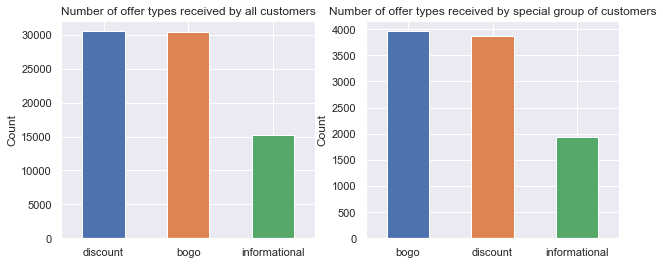

In [71]:
#plotting offer distribution 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
ax1=axes[0]
ax2=axes[1]
df [df ['event'] =='offer received'].offer_type.value_counts().plot(kind='bar', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_title('Number of offer types received by all customers')
ax1.set_ylabel('Count')

df [(df ['event'] =='offer received')&(df ['gender'] =='S')].offer_type.value_counts().plot(kind='bar', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_title('Number of offer types received by special group of customers')
ax2.set_ylabel('Count')

plt.show ()

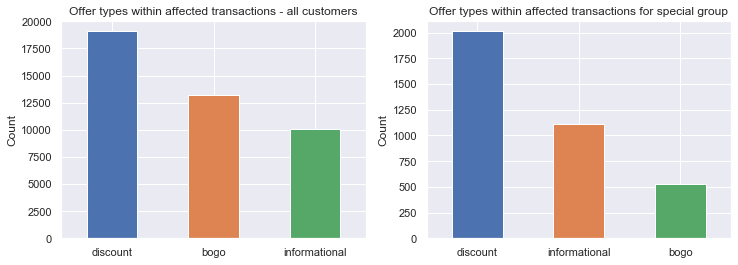

In [72]:
#let's visualize distribution of offer types that affected transactions

#plotting offer distribution 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
ax1=axes[0]
ax2=axes[1]
trans_affect.offer_type.value_counts().plot(kind='bar', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_title('Offer types within affected transactions - all customers')
ax1.set_ylabel('Count')

trans_affect [trans_affect ['gender']=='S'].offer_type.value_counts().plot(kind='bar', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_title('Offer types within affected transactions for special group')
ax2.set_ylabel('Count')

plt.show ()


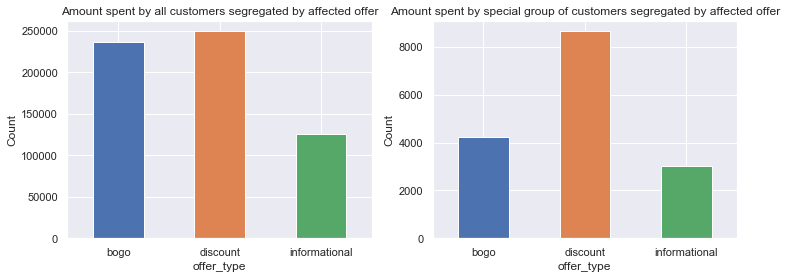

In [73]:
#let's verify amount spent by consumers within each offer type. 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
ax1=axes[0]
ax2=axes[1]

trans_affect.groupby('offer_type')['amount'].sum().plot(kind='bar', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_title('Amount spent by all customers segregated by affected offer')
ax1.set_ylabel('Count')

trans_affect [trans_affect ['gender']=='S'].groupby('offer_type')['amount'].sum().plot(kind='bar', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_title('Amount spent by special group of customers segregated by affected offer')
ax2.set_ylabel('Count')

#fig, ax = plt.subplots(figsize = (8,4))
#trans_affect.groupby('offer_type')['amount']. sum ().plot(kind='bar', ax=ax)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#ax.set_title('Amount spent by customers segregated by affected offer')
#ax.set_ylabel('Count')


plt.show ()

What we can see is that this special group differs in behavior from the general customers community. 

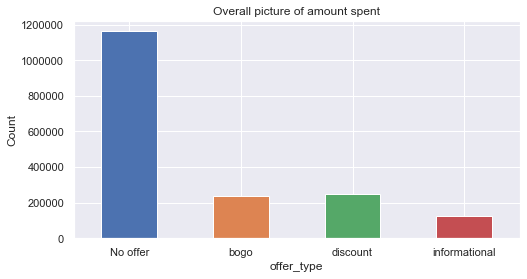

In [74]:
#let's verify amount spent by consumers within each offer type adding 'no offer'. 
trans_affect_tmp = trans_affect.copy ()
# replacing na values in offer type with No offer 
trans_affect_tmp["offer_type"].fillna('No offer', inplace = True) 

fig, ax = plt.subplots(figsize = (8,4))
trans_affect_tmp.groupby('offer_type')['amount']. sum ().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Overall picture of amount spent')
ax.set_ylabel('Count')
plt.show ()

In [75]:
trans_affect.groupby('offer_type')['amount']. sum ()

offer_type
bogo             236669.26
discount         249679.39
informational    125797.34
Name: amount, dtype: float64

In [76]:
#plotting distribution of offers and the affected transactions  
y = df [df ['event'] =='offer received'].offer_type.value_counts().index.sort_values() #offer types

x1 = df [df ['event'] =='offer received'].offer_type.value_counts().sort_index()
x2= df [df ['event'] =='offer viewed'].offer_type.value_counts().sort_index()
x3= df [df ['event'] =='offer completed'].offer_type.value_counts().sort_index()
x4= trans_affect.offer_type.value_counts().sort_index()

off_rec = go.Bar(
    x=x1,
    y=y,
    text= x1,
    name = 'Offer received',
    textposition = 'auto',
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
off_view = go.Bar(
    x=x2,
    y=y,
    text=x2,
    name = 'Offer viewed',
    textposition = 'auto',
    marker=dict(
        color='rgb(0,100,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
off_compl = go.Bar(
    x=x3,
    y=y,
    text=x3,
    name = 'Offer completed',
    textposition = 'auto',
    marker=dict(
        color='rgb(255,215,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
trans = go.Bar(
    x=x4,
    y=y,
    text=x4,
    name = 'Number of transactions affected by the offer',
    textposition = 'auto',
    marker=dict(
        color='rgb(178, 0, 0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
data = [off_rec, off_view, off_compl, trans]
py.iplot(data, filename='grouped-bar-direct-labels')


***What kind of offer really excite people?***

In [77]:
#plotting distribution of offers and the affected transactions within offer subtype  

#adding new column 
trans_affect ['offer_subtype'] = trans_affect ['offer_id'].apply (define_subtype)

In [78]:
#plotting distribution of offer subtypes and the number of affected transactions  
y = df [df ['event'] =='offer received'].subtype.value_counts().index.sort_values()

x1 = df [df ['event'] =='offer received'].subtype.value_counts().sort_index ()
x2= df [df ['event'] =='offer viewed'].subtype.value_counts().sort_index ()
x3= df [df ['event'] =='offer completed'].subtype.value_counts().sort_index ()
x4= trans_affect.offer_subtype.value_counts().sort_index()

off_rec = go.Bar(
    x=x1,
    y=y,
    text= x1,
    name = 'Offer received',
    textposition = 'auto', 
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
off_view = go.Bar(
    x=x2,
    y=y,
    text=x2,
    name = 'Offer viewed',
    textposition = 'auto',
    marker=dict(
        color='rgb(0,100,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
off_compl = go.Bar(
    x=x3,
    y=y,
    text=x3,
    name = 'Offer completed',
    textposition = 'auto',
    marker=dict(
        color='rgb(255,215,0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
trans = go.Bar(
    x=x4,
    y=y,
    text=x4,
    name = 'Number of transactions affected by the offer',
    textposition = 'auto',
    marker=dict(
        color='rgb(178, 0, 0)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, orientation = 'h'
)
data = [off_rec, off_view, off_compl, trans]
layout = go.Layout(
    autosize=True,
    yaxis=go.layout.YAxis(
        #title='Y-axis Title',
        #ticktext=['Very long label','long label','3','label'],
        #tickvals=[1, 2, 3, 4],
        #tickmode='array',
        automargin=True#,
        #titlefont=dict(size=30),
    )
    #width=900,
    #height=500,
    )

fig = go.Figure (data=data, layout=layout)
py.iplot(fig, filename='grouped-bar-direct-labels')

Надо проверить график выше, что там нигде нет ошибки. 

потому что выглядит это подозрительно, что кол-во тр больше закрытых офферов. 
а вообще просто посмотреть сумму медианную и среднюю по дисконтам 10 10 если они маленькие то понятно почему. 

On the diagram above you can see ... кол-во транз по бого меньше чем комплитед. это может быть потому что: одна транза могла закомлитить 2 оффера и дисконт и бого, например, но пометили мы ту, что была ближе по времени к транзе. или по причине того, что оффер помечен комплитед потому что прошли транзы, но он оффер так и не смотрел.

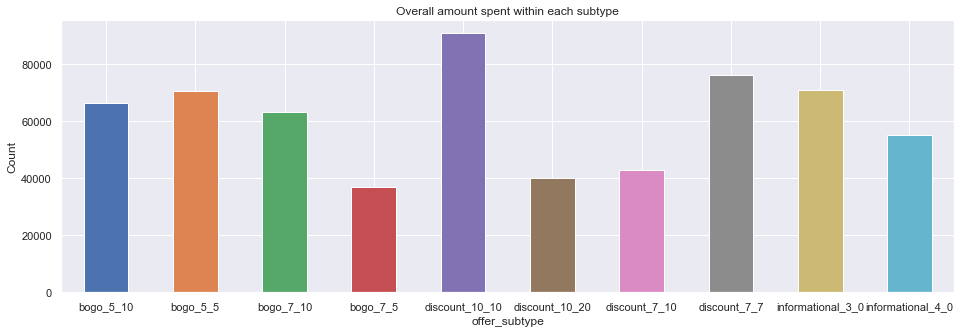

In [79]:
fig, ax = plt.subplots(figsize = (16,5))
trans_affect.groupby('offer_subtype')['amount']. sum ().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Overall amount spent within each subtype')
ax.set_ylabel('Count')
plt.show ()

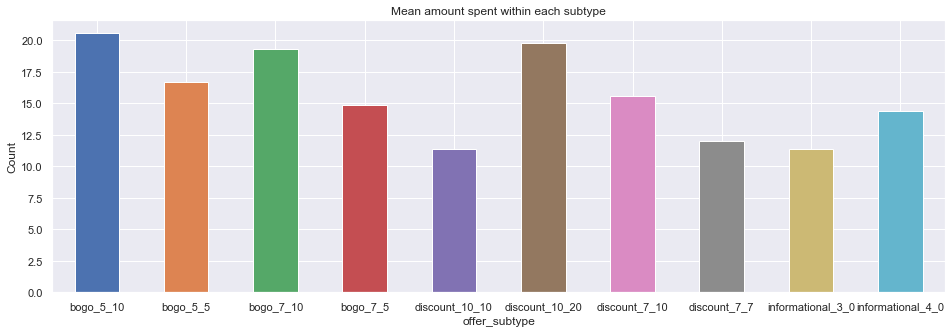

In [80]:
fig, ax = plt.subplots(figsize = (16,5))
trans_affect.groupby('offer_subtype')['amount']. mean ().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Mean amount spent within each subtype')
ax.set_ylabel('Count')
plt.show ()

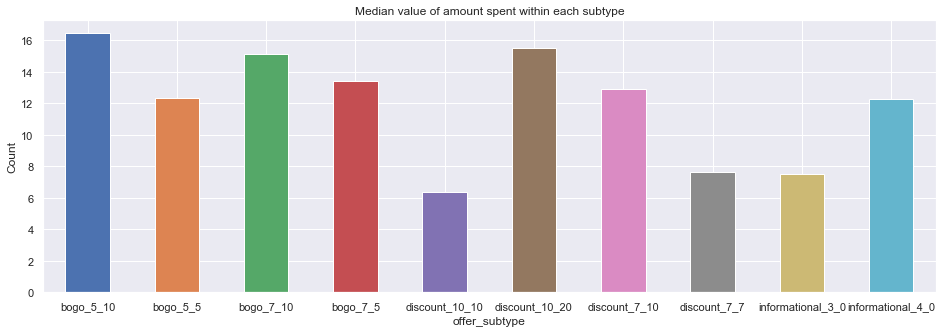

In [81]:
fig, ax = plt.subplots(figsize = (16,5))
trans_affect.groupby('offer_subtype')['amount']. median ().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Median value of amount spent within each subtype')
ax.set_ylabel('Count')
plt.show ()

если мы говорим, что вот этот оффер он самый популярный, то не потому ли он популярен что чаще его рассылают? 

и среди тех юзеров что его получили какой коэффициент отклика? 

***Number of customers never affected by provided offers***

In [82]:
completed_offers_ids = df [df ['event'] == 'offer completed']
received_offers_ids = df [df ['event'] == 'offer received']
viewed_offers_ids = df [df ['event'] == 'offer viewed']

print ('Number of persons that received an offer at least once: ', received_offers_ids.groupby ('person') ['offer_id'].unique ().count ())
print ('Number of persons among clients that never received any offer: ', df ['person'].nunique()- received_offers_ids.groupby ('person') ['offer_id'].unique ().count ())
print ('Number of persons that viewed an offer at least once: ', viewed_offers_ids.groupby ('person') ['offer_id'].unique ().count ())
print ('Number of persons that completed an offer at least once: ', completed_offers_ids.groupby ('person') ['offer_id'].unique ().count ())
print ('Overall number of unique customers that made transactions: ', trans_affect ['person'].nunique ())
print ('Number of unique customers that made transactions but none of these transactions were affected by offers: ', trans_affect ['person'].nunique () - trans_affect_tmp [trans_affect_tmp ["offer_type"] !='No offer'] ['person'].nunique ())

Number of persons that received an offer at least once:  16994
Number of persons among clients that never received any offer:  6
Number of persons that viewed an offer at least once:  16834
Number of persons that completed an offer at least once:  12774
Overall number of unique customers that made transactions:  16578
Number of unique customers that made transactions but none of these transactions were affected by offers:  3602


***We can say that 3602 customers are not affected by provided offers***

**Посмотреть как себя ведут те, кто не указал пол и доход. на сколько они отличаются от остальных по поведению**

например какой у них средний чек по сравнению с остальными? 



**Scatterplot to visualize how different segments react to offers. based on age, income**

**Project overview**

In [83]:
#let's find a list of persons that never were affected by any offer although have done transactions
person_no_offer= np.array (trans_affect_tmp [trans_affect_tmp ["offer_type"] =='No offer'] ['person'].unique ())
person_with_offer = np.array (trans_affect_tmp [trans_affect_tmp ["offer_type"] !='No offer'] ['person'].unique ())

person_no_offer = np.setdiff1d (person_no_offer,person_with_offer)

In [84]:
#defining function to compare customers affected by offers and those who are not 
def comparison_func (df1, df2, column):
    fig, ax =plt.subplots(1,2)
    sns.countplot(df1[column], ax=ax[0])
    sns.countplot(df2[column], ax=ax[1])
    plt.subplots_adjust(wspace= 0.5)
    fig.show()
    return 

In [85]:
customers_using_offers = profile [~profile ['id'].isin (person_no_offer)]
customers_not_using_offers = profile [profile ['id'].isin (person_no_offer)]


D:\Users\Kusainov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



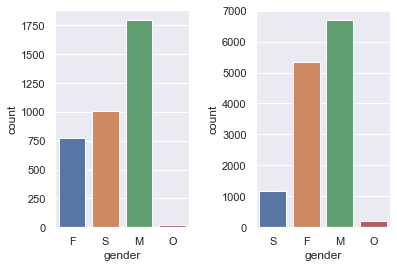

In [86]:
comparison_func (customers_not_using_offers, customers_using_offers, 'gender')



In [87]:
customers_not_using_offers ['gender'].describe()

count     3602
unique       4
top          M
freq      1794
Name: gender, dtype: object

In [88]:
customers_using_offers ['gender'].describe()

count     13398
unique        4
top           M
freq       6690
Name: gender, dtype: object

It appears that special group is presented in both datasets almost equally about 1000 persons, however within customers that do not use offers proportion of special group is around 28% while in second dataset the proportion is about 8%. 

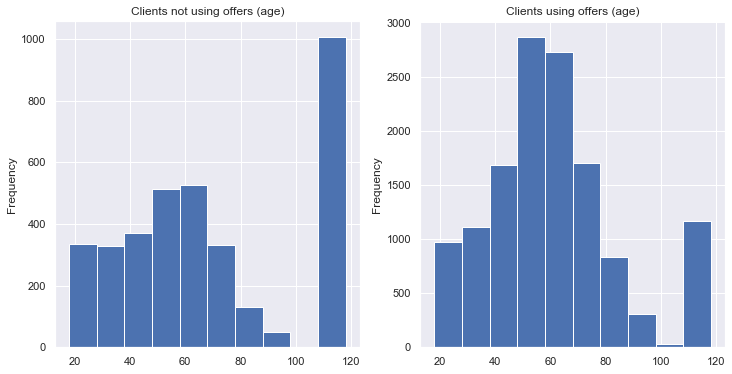

In [89]:
#plotting customers distribution by age
fig, axes = plt.subplots (nrows=1, ncols=2, figsize = (12,6))

customers_not_using_offers ['age'].plot (kind = 'hist',
                    title = 'Clients not using offers (age)',
                    #figsize = (6, 4.8),
                    ax = axes [0]
                      )
customers_using_offers ['age'].plot (kind = 'hist',
                    title = 'Clients using offers (age)',
                    #figsize = (6, 4.8), 
                    ax = axes [1]
                    )
#plt.subplots_adjust(wspace= 0.5)

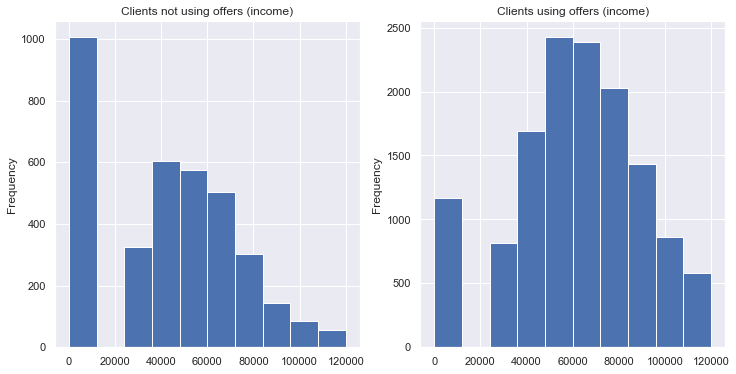

In [90]:
fig, axes = plt.subplots (nrows=1, ncols=2, figsize= (12,6))

customers_not_using_offers ['income'].plot (kind = 'hist',
                    title = 'Clients not using offers (income)',
                    ax=axes [0]
                      )

customers_using_offers ['income'].plot (kind = 'hist',
                    title = 'Clients using offers (income)',
                    ax=axes [1]
                      )


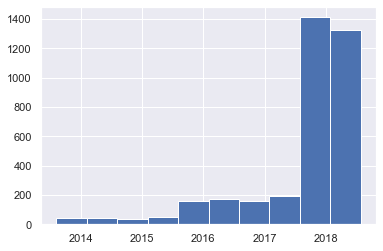

In [91]:
#plotting customers distribution by age
customers_not_using_offers ['became_member_on'].hist();

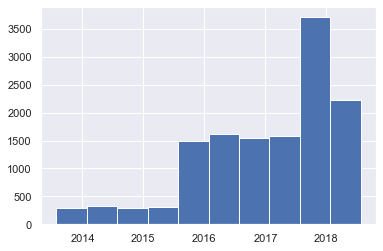

In [92]:
#plotting customers distribution by age
customers_using_offers ['became_member_on'].hist();

***Какие суммы тратит тот, кто не реагирует совсем на офферы и те кто в каком-то виде все-таки реагирует***

In [93]:
trans_affect [trans_affect ['person'].isin (person_no_offer)]['amount'].describe ()

count    18010.000000
mean         5.812289
std         17.104635
min          0.050000
25%          1.210000
50%          2.630000
75%          5.450000
max        957.150000
Name: amount, dtype: float64

In [94]:
trans_affect [~trans_affect ['person'].isin (person_no_offer)]['amount'].describe ()

count    120943.000000
mean         13.814546
std          31.614870
min           0.050000
25%           3.450000
50%          10.560000
75%          18.960000
max        1062.280000
Name: amount, dtype: float64

***Building base for FunkSVD***

In [95]:
#using more convinient user_id for df
userid_encoded, userid_dict = userid_mapper()
del df['person']
df['user_id'] = userid_encoded

# show header
df.head(n=3)

,event,time,offer_id,amount,reward_received,offer_used,channels,difficulty,duration,offer_type,reward,subtype,time_days,age,became_member_on,gender,income,user_id
0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0,bogo_7_5,0.0,75,2017-05-09,F,100000.0,1
1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,"[web, email]",20.0,10.0,discount,5.0,discount_10_20,0.0,118,2017-08-04,S,0.0,2
2,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,"[web, email, mobile]",10.0,7.0,discount,2.0,discount_7_10,0.0,68,2018-04-26,M,70000.0,3


In [96]:
#print (sorted (portfolio['subtype'].unique ()))

In [97]:
subtype_dict = {'bogo_5_10':1, 'bogo_5_5':2, 'bogo_7_10':3, 'bogo_7_5':4, 'discount_10_10':5,
                 'discount_10_20':6, 'discount_7_10':7, 'discount_7_7':8, 'informational_3_0':9, 
                 'informational_4_0':10}
subt_dict_bogo_disc = {'bogo_5_10':1, 'bogo_5_5':2, 'bogo_7_10':3, 'bogo_7_5':4, 'discount_10_10':5,
                       'discount_10_20':6, 'discount_7_10':7, 'discount_7_7':8}
subt_dict_inform = {'informational_3_0':9, 
                    'informational_4_0':10}

def offer_rate (): 
    
    #initializing empty dataframe that will be enriched with data
    df_rate = pd.DataFrame (columns = ['user_id', 'rate','off_subtype_id'])
    
    #loop over subtypes (except informational)
    for subtype_id in subt_dict_bogo_disc: 
        
        #taking slice from df for specific subtype
        df_tmp = df [df ['subtype'] == subtype_id].copy ()
    
        #rate =1 if user completed offer else 0
        df_tmp ['rate'] = df_tmp ['event'].apply (lambda x: 1 if x == 'offer completed' else 0)
        #grouping by user so that if a user at any time completed offer rate will be >0
        df_rate_tmp = pd.DataFrame (df_tmp.groupby ('user_id') ['rate'].sum ()).reset_index ()
        #saving offer subtype id
        df_rate_tmp ['off_subtype_id'] = subtype_dict [subtype_id]
    
        #we should count only 1 and 0. 1 if ever used 0 if never completed such offer 
        df_rate_tmp ['rate'] = df_rate_tmp ['rate'].apply (lambda x: 1 if x>0 else 0)
        
        #print (df_rate_tmp)
        df_rate = pd.concat ([df_rate, df_rate_tmp], ignore_index = True)
        
    return df_rate

In [98]:
#preparing ratings for all offers except informational. 
df_rate = offer_rate ()

In [99]:
df_rate.describe ()

,user_id,rate,off_subtype_id
count,50637,50637,50637
unique,16928,2,8
top,3362,1,6
freq,6,28996,6374


In [100]:
#УДАЛИТЬ в последнюю очередь
#loop over all subtypes (except for informational)
#within each iteration form a dataframe that will consist of uid subtype_id and rating. 
#where whatever count >0 will be treated as positive rating = 1

#subtype_id = 'bogo_7_5'
#df_tmp = df [df ['subtype'] == subtype_id].copy ()

#df_tmp ['rate'] = df_tmp ['event'].apply (lambda x: 1 if x == 'offer completed' else 0)
#tmp1 = pd.DataFrame (df_tmp.groupby ('user_id') ['rate'].sum ()).reset_index ()
#tmp1 ['off_subtype_id'] = subtype_dict [subtype_id]
#tmp1.rename (columns = {'subtype':'rate'}, inplace = True)
#tmp1 ['rate'] = tmp1 ['rate'].apply (lambda x: 1 if x>0 else 0) 

In [101]:
trans_affect.head (n=5)

,event,person,time,offer_id,amount,reward_received,offer_used,channels,difficulty,duration,offer_type,reward,time_days,age,became_member_on,gender,income,offer_subtype
Unnamed: 0,,,,,,,,,,,,,,,,,,
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,NaN,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,20,2016-07-11,F,30000.0,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,34.56,NaN,NaN,NaN,NaN,NaN,discount,NaN,0.0,42,2016-01-17,M,96000.0,discount_7_10
12659,transaction,54890f68699049c2a04d415abc25e717,0,NaN,13.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,36,2017-12-28,M,56000.0,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,NaN,19.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,55,2017-10-16,F,94000.0,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,NaN,18.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,39,2017-12-17,F,67000.0,NaN


In [102]:
df [df ['offer_type'] == 'informational'].head (n=5)


,event,time,offer_id,amount,reward_received,offer_used,channels,difficulty,duration,offer_type,reward,subtype,time_days,age,became_member_on,gender,income,user_id
7,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,"[web, email, mobile]",0.0,4.0,informational,0.0,informational_4_0,0.0,58,2017-11-11,M,51000.0,8
13,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,"[web, email, mobile]",0.0,4.0,informational,0.0,informational_4_0,0.0,78,2017-06-16,F,71000.0,14
31,offer received,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,"[email, mobile, social]",0.0,3.0,informational,0.0,informational_3_0,0.0,39,2014-05-27,M,51000.0,32
44,offer received,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,"[email, mobile, social]",0.0,3.0,informational,0.0,informational_3_0,0.0,75,2015-11-29,M,52000.0,45
53,offer received,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,"[email, mobile, social]",0.0,3.0,informational,0.0,informational_3_0,0.0,27,2018-01-10,M,35000.0,54


In [103]:
#then check trans_affect and do similar but for informational. count only if transactions happened with informational subtype

def offer_inform_rate (): 
    
    trans_inform = trans_affect [trans_affect ['offer_type'] =='informational'].copy ()
    trans_inform ['user_id'] = trans_inform ['person']
    trans_inform ['user_id'].replace (userid_dict, inplace = True)
    trans_inform ['subtype'] =trans_inform ['offer_subtype'] 
    trans_inform = trans_inform [['event', 'user_id', 'subtype']]
    
    df_inform = df [df ['offer_type'] == 'informational'].copy ()
    df_inform = df_inform [['event', 'user_id', 'subtype']]
    
    df_inform = pd.concat ([trans_inform, df_inform], ignore_index = True)
       
    #initializing empty dataframe that will be enriched with data
    df_rate = pd.DataFrame (columns = ['user_id', 'rate','off_subtype_id'])
    
    #loop over informational subtypes
    for subtype_id in subt_dict_inform: 
        
        #taking slice from trans_inform with specific subtype
        df_tmp = df_inform [df_inform ['subtype'] == subtype_id].copy ()
    
        #rate =1 if user completed offer else 0
        df_tmp ['rate'] = df_tmp ['event'].apply (lambda x: 1 if x == 'transaction' else 0)
        #grouping by user so that if a user at any time completed offer rate will be >0
        df_rate_tmp = pd.DataFrame (df_tmp.groupby ('user_id') ['rate'].sum ()).reset_index ()
        #saving offer subtype id
        df_rate_tmp ['off_subtype_id'] = subtype_dict [subtype_id]
    
        #we should count only 1 and 0. 1 if ever used 0 if never completed such offer 
        df_rate_tmp ['rate'] = df_rate_tmp ['rate'].apply (lambda x: 1 if x>0 else 0)
        
        #print (df_rate_tmp)
        df_rate = pd.concat ([df_rate, df_rate_tmp], ignore_index = True)
        
    return df_rate

In [104]:
#preparing rating for informational offers
df_rate_inform = offer_inform_rate ()

In [105]:
#concatenate all the dataframes
df_rate_joint = pd.concat ([df_rate, df_rate_inform], ignore_index = True)

In [106]:
df_rate.head (n=5)

,user_id,rate,off_subtype_id
0,4,0,1
1,5,0,1
2,9,1,1
3,11,0,1
4,14,0,1


In [107]:
df_rate_inform.head (n=5)

,user_id,rate,off_subtype_id
0,1,1,9
1,2,0,9
2,9,0,9
3,11,0,9
4,14,1,9


In [108]:
df_rate_joint.describe ()

,user_id,rate,off_subtype_id
count,63288,63288,63288
unique,16994,2,10
top,2054,1,6
freq,6,34176,6374


In [109]:
df_rate_joint [df_rate_joint ['user_id'] ==16998]

,user_id,rate,off_subtype_id
6328,16998,0,1


In [110]:
#df_rate_joint.sample (frac =0.1, random_state =22).groupby(['user_id', 'off_subtype_id'])['rate'].sum ().unstack()

In [111]:
#let's take a look to user_item_matrix
user_item_matrix = df_rate_joint.groupby(['user_id', 'off_subtype_id'])['rate'].sum ().unstack()

In [112]:
user_item_matrix.head (n=5)

off_subtype_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0
3,NaN,NaN,NaN,1.0,1.0,NaN,0.0,NaN,NaN,0.0
4,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0
5,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN


In [113]:
#proportion of missing values
user_item_matrix.isnull ().sum()/user_item_matrix.shape[0]

off_subtype_id
1     0.627516
2     0.631517
3     0.624926
4     0.626044
5     0.627398
6     0.624926
7     0.630164
8     0.627810
9     0.628104
10    0.627457
dtype: float64

We can see that each offer subtype contains around 63% missing values.

***I have selected MSE for FunkSVD because***

In [169]:
def FunkSVD(ratings_mat, latent_features=4, learning_rate=0.0001, iters=100, random_seed=52, verbose=True):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, offers (subtype) as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]
    n_offers = ratings_mat.shape[1]
    num_ratings = np.count_nonzero(~np.isnan(ratings_mat))
    
    # initialize the user and offer matrices with random values
    np.random.seed (random_seed)
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    if verbose:
        print("Optimizaiton Statistics")
        print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if (ratings_mat[i, j] == 0)|(ratings_mat[i, j] == 1):
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = ratings_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results for iteration
        if verbose: 
            print("%d \t\t %f" % (iteration+1, sse_accum / num_ratings))
    
    return user_mat, offer_mat 


In [115]:
#apply funkSVD on the whole dataset
user_mat, offer_mat = FunkSVD (np.matrix (user_item_matrix), latent_features=10, learning_rate=0.001, iters=50)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.264295
2 		 0.255188
3 		 0.252779
4 		 0.250392
5 		 0.248029
6 		 0.245691
7 		 0.243376
8 		 0.241087
9 		 0.238822
10 		 0.236583
11 		 0.234369
12 		 0.232181
13 		 0.230018
14 		 0.227881
15 		 0.225770
16 		 0.223685
17 		 0.221625
18 		 0.219592
19 		 0.217584
20 		 0.215602
21 		 0.213646
22 		 0.211716
23 		 0.209811
24 		 0.207931
25 		 0.206076
26 		 0.204247
27 		 0.202442
28 		 0.200662
29 		 0.198906
30 		 0.197174
31 		 0.195466
32 		 0.193781
33 		 0.192120
34 		 0.190482
35 		 0.188867
36 		 0.187274
37 		 0.185703
38 		 0.184154
39 		 0.182626
40 		 0.181119
41 		 0.179634
42 		 0.178169
43 		 0.176723
44 		 0.175298
45 		 0.173892
46 		 0.172506
47 		 0.171138
48 		 0.169789
49 		 0.168458
50 		 0.167144
51 		 0.165848
52 		 0.164570
53 		 0.163308
54 		 0.162062
55 		 0.160832
56 		 0.159619
57 		 0.158420
58 		 0.157237
59 		 0.156069
60 		 0.154915
61 		 0.153774
62 		 0.152648
63 		 0.151535
64 		 0

In [116]:
print (np.round (np.dot(user_mat, offer_mat)))
#np.matrix (user_item_matrix.iloc [0:1000,:])
np.matrix (user_item_matrix)

[[1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


matrix([[nan,  1.,  1., ..., nan,  1., nan],
        [nan, nan, nan, ..., nan,  0.,  0.],
        [nan, nan, nan, ..., nan, nan,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [ 0., nan, nan, ..., nan, nan, nan],
        [ 0., nan, nan, ..., nan, nan, nan]])

In [117]:
#tmp_rate = df_rate_joint [0:10].copy ()
#display (tmp_rate)
#tmp2= tmp_rate.sample (frac =0.1, random_state =22, replace = True)
#display (tmp2)
#display (tmp_rate.index)
#tmp_rate.drop (index = tmp2.index)
#print (tmp_rate)

In [118]:
#a function that prepares train and test split out of df_rate_joint. 
def user_item_train_test_split (df_rate_joint, test_size=0.1, random_seed = 22):
    
    #saving a df to work with
    rate_df = df_rate_joint.copy ()
    
    #taking part of ratings 
    test_tmp = rate_df.sample(frac =test_size, random_state =random_seed)
    
    #eliminating taken data from rate_df so to form train
    train_tmp = rate_df.drop (index = test_tmp.index)
    
    #converting both into user_item format
    train_matrix = train_tmp.groupby(['user_id', 'off_subtype_id'])['rate'].sum ().unstack()
    test_matrix = test_tmp.groupby(['user_id', 'off_subtype_id'])['rate'].sum ().unstack()
    
    return train_matrix, test_matrix  
    

In [119]:
train_matrix, test_matrix = user_item_train_test_split (df_rate_joint) 

In [120]:
print ('Number of common customers in both train and test sets: {}'. format (len (train_matrix.index.intersection (test_matrix.index))))
print ('Number of common offer subtypes in both train and test sets: {}'. format (len (train_matrix.columns.intersection (test_matrix.columns))))
print ("Number of customers for whom we are not able to make predictions due to cold start problem: ", len (test_matrix.index) - len (train_matrix.index.intersection (test_matrix.index)))

Number of common customers in both train and test sets: 5456
Number of common offer subtypes in both train and test sets: 10
Number of customers for whom we are not able to make predictions due to cold start problem:  45


In [121]:
train_matrix.head (n=10)

off_subtype_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,NaN,NaN,NaN,1.0,1.0,NaN,0.0,NaN,NaN,0.0
4,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN
5,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
6,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN
7,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN
8,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,0.0
9,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN


In [122]:
test_matrix.head (n=10)

off_subtype_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
9,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
19,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
20,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
#test_matrix [test_matrix.notna()]

In [124]:
#checking proportion of missing values in both sets
print (train_matrix.isnull().sum()/train_matrix.shape[0])
print (test_matrix.isnull().sum()/test_matrix.shape[0])


off_subtype_id
1     0.665113
2     0.668299
3     0.660688
4     0.664051
5     0.663815
6     0.660629
7     0.665644
8     0.664051
9     0.663697
10    0.663402
dtype: float64
off_subtype_id
1     0.881113
2     0.883658
3     0.886748
4     0.879840
5     0.884748
6     0.886930
7     0.887657
8     0.885294
9     0.887293
10    0.886203
dtype: float64


In [156]:
#fit to train 
user_mat_train, offer_mat_train = FunkSVD (np.matrix (train_matrix), latent_features=5, learning_rate=0.001, iters=20)
train_predict_np= np.abs(np.round (np.dot(user_mat_train, offer_mat_train)))

#checking predicted values in each column
predict_train_matrix = pd.DataFrame (train_predict_np, index = train_matrix.index, columns = train_matrix.columns)
for j in predict_train_matrix.columns:
    print (predict_train_matrix[j].value_counts())
    
validation_func (train_matrix, predict_train_matrix, is_train=True)
validation_func (test_matrix, predict_train_matrix)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.292109
2 		 0.256978
3 		 0.254635
4 		 0.253903
5 		 0.253411
6 		 0.252956
7 		 0.252507
8 		 0.252059
9 		 0.251612
10 		 0.251165
11 		 0.250720
12 		 0.250275
13 		 0.249831
14 		 0.249388
15 		 0.248945
16 		 0.248504
17 		 0.248063
18 		 0.247623
19 		 0.247184
20 		 0.246746
0.0    12367
1.0     4582
Name: 1, dtype: int64
1.0    10274
0.0     6675
Name: 2, dtype: int64
0.0    9483
1.0    7466
Name: 3, dtype: int64
1.0    11135
0.0     5814
Name: 4, dtype: int64
1.0    14066
0.0     2883
Name: 5, dtype: int64
0.0    9363
1.0    7586
Name: 6, dtype: int64
1.0    8546
0.0    8403
Name: 7, dtype: int64
1.0    13659
0.0     3290
Name: 8, dtype: int64
0.0    10593
1.0     6356
Name: 9, dtype: int64
0.0    16716
1.0      233
Name: 10, dtype: int64


MSE on the train set is:  0.4288523323794308
RMSE on the train set is:  0.6548681793914183
Accuracy on the train set is:  0.5711476676205691




MSE on the test set is:  0.434

In [185]:
#Comparing to naive predictor model
base_predict = predict_train_matrix.copy ()

#we consider that all offers would be used by customers
for j in base_predict.columns:
    base_predict[j] = 1.0
    
#accuraccy and MSE, RMSE for naive predictor model
print ('Naive model prediction metric:')
validation_func (test_matrix, base_predict)

Naive model prediction metric:


MSE on the test set is:  0.4621583188497393
RMSE on the test set is:  0.679822270045443
Accuracy on the test set is:  0.5378416811502607




As it can be seen accuracy is not very ... The result is promising taking into consideration how sparse the matrices are. Can this result be improved? 

In [160]:
#predict_train_matrix = pd.DataFrame (train_predict_np, index = train_matrix.index, columns = train_matrix.columns)
#for j in predict_train_matrix.columns:
#    if predict_train_matrix[j].nunique()>2:
#        print ('Model is overfitting')

In [188]:
#results_df = pd.DataFrame ([], columns = ['num_latent_feat','learning_rate',\
#                                                  'number_of_iter','mse_on_train','acc_on_train',\
#                                                  'mse_on_test', 'acc_on_test', 'overfitting'])
#results_df.loc[-1] = ['1', '2','3','4','5','6','7','8']
#results_df.index =results_df.index+1
#results_df.sort_index ()
#results_df.loc[-1] = ['1', '2','3','4','5','6','7','8']
#results_df.index =results_df.index+1
#results_df.sort_index ()
results_df.reset_index()

,index,num_latent_feat,learning_rate,number_of_iter,mse_on_train,acc_on_train,mse_on_test,acc_on_test,overfitting
0,1,1,2,3,4,5,6,7,8
1,0,1,2,3,4,5,6,7,8


In [186]:
#now let's fine-tune model using different number of latent features, learning rate and number of iterations.
params = {"latent_feat": [5, 10, 15],
          "num_iter": [50, 100, 150],
          "learning_rate": [0.001, 0.005, 0.01]
          }

def gridsearch_funkSVD (parameters): 
        #saving parameters
        latent_feat_list = parameters ['latent_feat']
        num_iter_list = parameters ['num_iter']
        lrn_list = parameters ['learning_rate']
        
        results_df = pd.DataFrame ([], columns = ['num_latent_feat','learning_rate',\
                                                  'number_of_iter','mse_on_train','acc_on_train',\
                                                  'mse_on_test', 'acc_on_test', 'overfitting'])
            
        for lat_feat in tqdm(latent_feat_list):
            for num_iter in tqdm(num_iter_list):
                for lrn_rate in tqdm (lrn_list):
                    model_overfit = 'No'
                    user_mat_train, offer_mat_train = FunkSVD (np.matrix (train_matrix), latent_features=lat_feat,\
                                                               learning_rate=lrn_rate, iters=num_iter, verbose=False)
                    train_predict_np= np.abs(np.round (np.dot(user_mat_train, offer_mat_train)))

                    #checking predicted values in each column
                    predict_train_matrix = pd.DataFrame (train_predict_np, index = train_matrix.index, columns = train_matrix.columns)
                    for j in predict_train_matrix.columns:
                        if predict_train_matrix[j].nunique()>2:
                            #print ('Model is overfitting')
                            model_overfit = 'Yes'
                            #no need to check other columns
                            break
    
                    train_mse, train_acc= validation_func (train_matrix, predict_train_matrix, is_train=True, verbose=False)
                    test_mse, test_acc= validation_func (test_matrix, predict_train_matrix, verbose=False)
                    
                    #print ('Model\'s numer of latent features: {}, number of iterations: {}, learning rate: {}'.format (lat_feat,\
                    #        num_iter, lrn_rate))
                    results_df.loc[-1] = [lat_feat, lrn_rate,num_iter,train_mse,train_acc,test_mse,test_acc,model_overfit]
                    results_df.index =results_df.index+1
                    results_df.sort_index ()
        display (results_df.reset_index())
gridsearch_funkSVD (params)

,num_latent_feat,learning_rate,number_of_iter,mse_on_train,acc_on_train,mse_on_test,acc_on_test,overfitting
26,5,0.001,50,0.395793,0.604207,0.415073,0.584927,No
25,5,0.005,50,0.234555,0.765445,0.327540,0.672460,No
24,5,0.010,50,0.153514,0.846486,0.299573,0.700427,No
23,5,0.001,100,0.343071,0.656929,0.387897,0.612103,No
22,5,0.005,100,0.144227,0.855773,0.290725,0.709275,No
21,5,0.010,100,0.050282,0.949718,0.300679,0.701849,Yes
20,5,0.001,150,0.297108,0.702892,0.367357,0.632643,No
19,5,0.005,150,0.083393,0.916607,0.289777,0.711171,Yes
18,5,0.010,150,0.014607,0.985393,0.341760,0.668352,Yes
17,10,0.001,50,0.403237,0.596763,0.421394,0.578606,No


#### Observations: 
We can see that 

#### Results:

From the above the best parameters are:  
number of latent features =5, learning rate=0.005, number of iterations=100.  
These parameters are giving optimized model.

|     Metric     | Naive Model       |Unoptimized Model  | Optimized Model | 
| :------------: | :---------------: | :-------------:   | :-------------: | 
| Accuracy Score | 0.5378            |0.5659             | 0.7093          | 
| MSE            | 0.4621            |0.4340             | 0.2907          | 

Now that we have understanding about the best parameters, let's apply FunkSVD using them on the whole dataset 

In [195]:
#user_item_matrix.shape
#prediction.shape
#print (user_mat.shape)
#print (offer_mat.shape)


In [194]:
#apply model using best parameters
user_mat, offer_mat = FunkSVD (np.matrix (user_item_matrix), latent_features=5, learning_rate=0.005, iters=100, verbose=False)

prediction= np.abs(np.round (np.dot(user_mat, offer_mat)))
predict_matrix = pd.DataFrame (prediction, index = user_item_matrix.index, columns = user_item_matrix.columns)

#inspect some user_id / offer comparing to the actual values. 
display (user_item_matrix.head (n=10))
display (predict_matrix.head (n=10))

off_subtype_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0
3,NaN,NaN,NaN,1.0,1.0,NaN,0.0,NaN,NaN,0.0
4,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0
5,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
6,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN
7,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN
8,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,0.0
9,1.0,1.0,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN


off_subtype_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [198]:
#verify if any overfitting presented in the predicted matrix
k=False
for j in predict_matrix.columns:
    if predict_matrix[j].nunique()>2:
        k=True
        print ('Model is overfitting')
        break
if k==False:
    print ('Model is NOT overfitting')


Model is NOT overfitting


In [ ]:
#clarify why MSE was selected as metric


http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf

In [228]:
#subtype_dict
#for i,j in subtype_dict.items():
#    print (i,j)

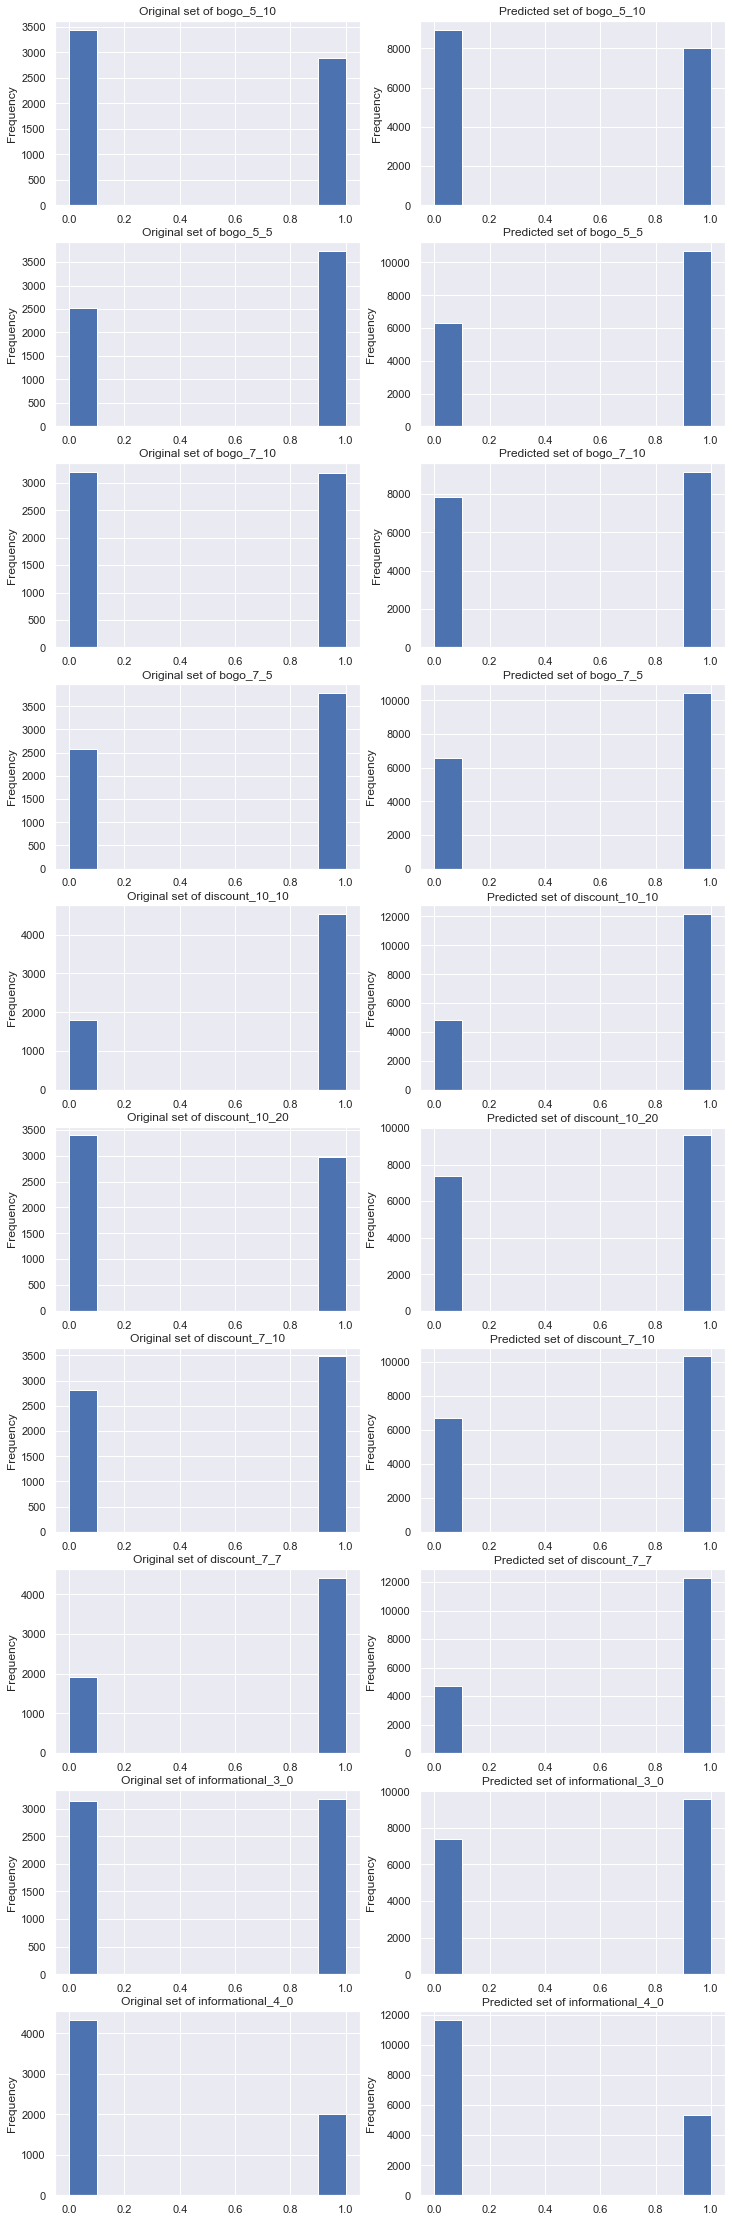

In [227]:
#comparing proportion of positive and negative reaction to the offers in original dataset and predicted
fig, axes = plt.subplots (nrows=10, ncols=2, figsize = (12,40))

for i,j in subtype_dict.items():
    user_item_matrix [j].plot (kind = 'hist',
                    title = 'Original set of '+str(i),
                    ax = axes [j-1,0]
                      )
    predict_matrix [j].plot (kind = 'hist',
                    title = 'Predicted set of '+str(i),
                    ax = axes [j-1,1]
                    )
    
plt.show()

**Problem statement**

The problem which needs to be solved is clearly defined. A strategy for solving the problem, including discussion of the expected solution, has been made.

5. Some people doesn't really want to receive any offer. don't bother them. 

**Metrics to be used**

**Data Exploaration**

Features and calculated statistics relevant to the problem have been reported and discussed related to the dataset, and a thorough description of the input space or input data has been made. Abnormalities or characteristics about the data or input that need to be addressed have been identified.

**Data Visualization**

Build data visualizations to further convey the information associated with your data exploration journey. Ensure that visualizations are appropriate for the data values you are plotting.